NOTE: this notebook was started by Jarom. It demonstrates building a classed IPM with two classes, as well as a script to automate that construction. This is likely off-target for how we want the system to do this, but may have useful insights in any case.

In [1]:
# type: ignore
from sympy import Max

from epymorph.data_shape import Shapes
from epymorph.ipm.attribute import param
from epymorph.ipm.compartment_ipm import CompartmentModelIpmBuilder
from epymorph.ipm.compartment_model import (compartment, create_model,
                                            create_symbols, edge)
from epymorph.ipm.ipm import IpmBuilder


def constructAgeIPM() -> IpmBuilder:
    symbols = create_symbols(
        compartments=[
            compartment('Sa'),
            compartment('Sb'),
            compartment('Ia'),
            compartment('Ib'),
            compartment('Ra'),
            compartment('Rb'),
        ],
        attributes=[
            param('betaAA', shape=Shapes.TxN),  # infectivity from a to a
            param('betaBA', shape=Shapes.TxN),  # infectivity from a to b
            param('betaBB', shape=Shapes.TxN),  # infectivity from b to b
            param('betaAB', shape=Shapes.TxN),  # infectivity from b to a
            param('gamma', shape=Shapes.TxN),  # progression from infected to recovered
        ])

    [Sa, Sb, Ia, Ib, Ra, Rb] = symbols.compartment_symbols
    [βAA, βBA, βBB, βAB, γ,] = symbols.attribute_symbols

    # formulate N so as to avoid dividing by zero;
    # this is safe in this instance because if the denominator is zero,
    # the numerator must also be zero
    N = Max(1, Sa + Ia + Ra + Sb + Ib + Rb)

    Age_SIR = create_model(
        symbols=symbols,
        transitions=[
            edge(Sa, Ia, rate= Sa * (βAA * Ia + βAB * Ib)/ N),
            edge(Sb, Ib, rate= Sb * (βBB * Ib + βBA * Ia)/ N),
            edge(Ia, Ra, rate=γ * Ia),
            edge(Ib, Rb, rate=γ * Ib),
        ])
    
    return CompartmentModelIpmBuilder(Age_SIR)


In [2]:
# type: ignore
from sympy import Max

from epymorph.data_shape import Shapes
from epymorph.ipm.attribute import param
from epymorph.ipm.compartment_ipm import CompartmentModelIpmBuilder
from epymorph.ipm.compartment_model import (compartment, create_model,
                                            create_symbols, edge)
from epymorph.ipm.ipm import IpmBuilder


def iterateAgeIPM(age_classes) -> IpmBuilder:

    ## Create empty arrays for compartments and attributes
    all_compartments = [None] * age_classes * 3   ## S, I, and R for each age class
    all_attributes = [None] * (age_classes * age_classes + 1)   ## Beta value for each age class interaction with 
                                                                ## other classes (including itself), plus one for gamma 

    ## Create a set of compartments for each age class
    for comp in range(age_classes):
        ## Classifier id starts at 'a' and increments each age class
        classId = chr(97 + comp)
        all_compartments[comp] = compartment('S' + classId)   ## Susceptible
        all_compartments[comp + age_classes] = compartment('I' + classId)   ## Infected
        all_compartments[comp + 2 * age_classes] = compartment('R' + classId)   ## Recovered

    num = 0   ## Value to increment location of beta value
    ## Creating beta values for each interaction
    for rec in range(age_classes):
        recId = chr(65 + rec)   ## Classifier id for the reciever starts at 'A' and increments for each age class
        for tran in range(age_classes):
            tranId = chr(65 + tran)   ## Classifier id for the transmitter starts at 'A' and increments
            all_attributes[num] = param('beta' + recId + tranId, shape=Shapes.TxN) ## Beta value between reciever and transmitter
            num += 1   ## Increment location value

    ## Add gamma at the last index
    all_attributes[-1] = param('gamma', shape=Shapes.TxN)

    ## Create symbols using compartment and attribute arrays
    symbols = create_symbols(
        compartments=all_compartments,
        attributes=all_attributes)

    ## Create empty arrays for the transmission rates and the number of transitions
    num_rates = [None] * age_classes
    all_transitions = [None] * (age_classes * 2)

    # formulate N so as to avoid dividing by zero;
    # this is safe in this instance because if the denominator is zero,
    # the numerator must also be zero
    N = 0
    for sym in range(len(symbols.compartment_symbols)):
        N += symbols.compartment_symbols[sym]
    N = Max(1, N)

    ## Create a rate for each S -> I transition
    for age in range(age_classes):
        additiveRates = 0   ## Value to track the additive rate between the current susceptible and all infected compartments
        for pairs in range(age_classes):
            ## Add each rate to the additive rate (Apropriate beta value * Infected of age class)
            additiveRates += (symbols.attribute_symbols[age*age_classes + pairs] *   ## Beta value
                              symbols.compartment_symbols[age_classes + pairs])   ## Infected compartment of age class
            
        ## Calculate final rate and place in the rates array
        rate = symbols.compartment_symbols[age] * additiveRates/ N
        num_rates[age] = rate

    ## Create each transition
    for trans in range(age_classes):
        ## Create S -> I transition
        SItransition = edge(symbols.compartment_symbols[trans],   ## Susceptible compartment
                            symbols.compartment_symbols[age_classes + trans],   ## Infected compartment
                            rate= num_rates[trans])   ## Transition rate
        
        ## Place transition in the transition array
        all_transitions[trans] = SItransition

        ## Create I -> R transition (rate is gamma value * infected)
        IRtransition = edge(symbols.compartment_symbols[age_classes + trans], ## Infected compartment
                            symbols.compartment_symbols[age_classes * 2 + trans],   ## Recovered compartment
                            rate= symbols.attribute_symbols[-1] *   ## Gamma value
                            symbols.compartment_symbols[age_classes + trans])   ## Infected compartment
        
        ## Place transition in the transition array
        all_transitions[age_classes + trans] = IRtransition

    ## Create model with symbols object and the transition array
    Age_SIR_Iterable = create_model(
        symbols=symbols,
        transitions= all_transitions
        )
    
    ## return the model builder
    return CompartmentModelIpmBuilder(Age_SIR_Iterable)


In [3]:
from datetime import date
from functools import partial

import numpy as np

from epymorph.data import geo_library, mm_library
from epymorph.initializer import explicit
from epymorph.simulation import Simulation

# Note: the 'library' dictionaries contain functions which load the named component,
# so you have to apply the function to get the _actual_ component.

# The 'pei' model family (IPM/MM/GEO) implement an SIRS model in 6 US states.
# (Remember: it is possible to mix-and-match the models!)
sim = Simulation(
    geo=geo_library['pei'](),
    ipm_builder=constructAgeIPM(),
    mvm_builder=mm_library['pei']()
)


In [4]:
out = sim.run(
    param={
        'theta': 0.1,
        'move_control': 0.9,
        'betaAA': 2.3,
        'betaBA': 1.4,
        'betaAB': 1.8,
        'betaBB': 1.7,
        'gamma': 0.75,
    },
    start_date=date(2015, 1, 1),
    duration_days=150,
    initializer=partial(explicit, initials=np.array([
        [100000, 10000, 1000, 1, 1, 1],
        [100000, 10000, 1, 1, 1, 1],
        [100000, 10000, 1, 1, 1, 1],
        [100000, 10000, 1, 1, 1, 1],
        [100000, 10000, 1, 1, 1, 1],
        [100000, 10000, 1, 1, 1, 1]
    ], dtype=np.int64)),
    # I've provided a seeded RNG here just to keep this notebook's results consistent,
    # but the rng param is optional! If not given, a new RNG is constructed for each run
    # using numpy's default_rng.
    rng=np.random.default_rng(1)
)


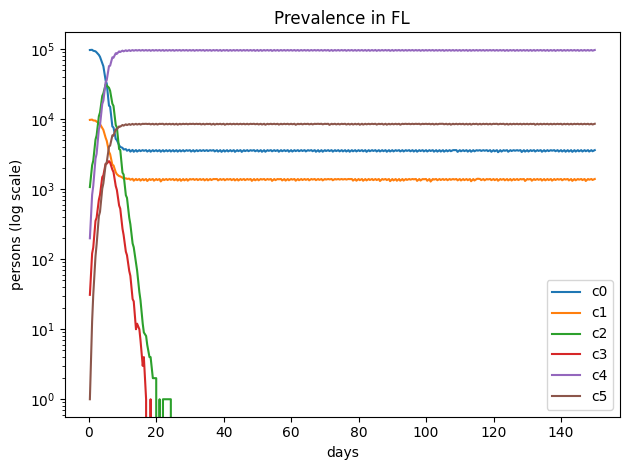

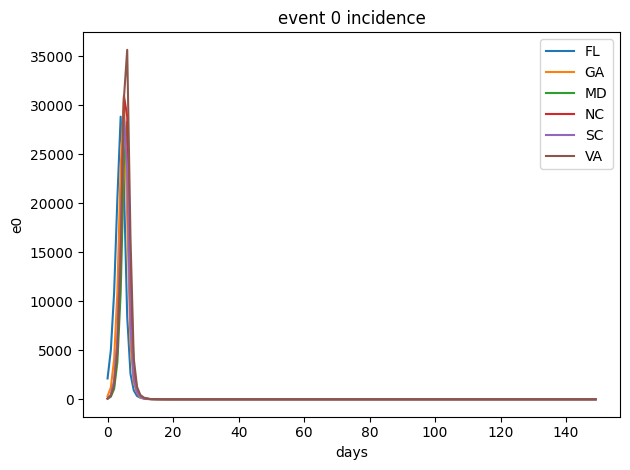

[[97294  9770  1073    31   199     1]
 [97967  9868  2201   121   833    13]
 [94982  9593  2551   147  1113    31]
 [93173  9539  5107   353  2721   110]]


In [5]:
from epymorph.run import plot_event, plot_pop

plot_pop(out, 0)  # prevalence for all compartments in population 0.

plot_event(out, 0)  # incidence data for the S->I event across all populations.

print(out.prevalence[0:4, 0, :])
